In [1]:
import numpy as np
import pandas as pd
import os

def online_variance(data):

    shape = data.shape[1:]
    
    n = 0
    mean = 0
    M2 = 0

    for x in tqdm(data):
        x = np.reshape( x, -1 ).astype( np.double )
        
        n = n + 1
        delta = x - mean
        mean = mean + delta/n
        M2 = M2 + delta*(x - mean)

    variance = M2/(n - 1)
    
    variance = np.reshape( variance, shape )
    mean = np.reshape( mean, shape )
    
    return mean.astype(np.float32), np.sqrt( variance ).astype(np.float32)



In [113]:

datasets = [
    "mne_data", "isruc", "mass", "svuh","dcsm"
]

num_channels = [3, 1, 3, 4, 4]

for dataset, num_channel in zip(datasets, num_channels):
    dataset_folder = "/home/guido/" + dataset + "/"
    table_path = os.path.join(dataset_folder, "table.csv")
    table = pd.read_csv(table_path)
    
    
    print("Computing scaling xsleepnet for", dataset)
    signal_path = os.path.join(dataset_folder, "xsleepnet.dat")
    X = np.memmap(
        signal_path,
        dtype="float32",
        mode="r",
        shape=(int(np.sum(table["num_samples"].values)), num_channel, 29, 129),
    )

    mean, std = online_variance(X)
    np.savez(os.path.join(dataset_folder, "xsleepnet_scaling.npz"), mean=mean, std=std)

    print("Computing scaling raw for", dataset)
    signal_path = os.path.join(dataset_folder, "raw.dat")
    X = np.memmap(
        signal_path,
        dtype="float32",
        mode="r",
        shape=(int(np.sum(table["num_samples"].values)), num_channel, 3000),
    )

    mean, std = online_variance(X)
    np.savez(os.path.join(dataset_folder, "raw_scaling.npz"), mean=mean, std=std)


  0%|          | 0/194444 [00:00<?, ?it/s]

 40%|████      | 231987/578939 [07:54<11:35, 498.91it/s]

In [107]:
real_mean, real_std = np.mean(X, axis= 0 ), np.std(X, axis= 0 )

print(real_mean.shape, real_std.shape)

print("Error in mean: ", np.sum(np.abs(mean - real_mean)))
print("Error in std: ", np.sum(np.abs(std - real_std)))


(3, 29, 129) (3, 29, 129)
Error in mean:  6.361679
Error in std:  4.466608


In [108]:
print( "Computing the scaling")
scaled = (X - mean) / std

Computing the scaling


In [109]:
print(scaled.shape[0])
# select 1000 samples from scaled
#scaled = scaled[: scaled.shape[0] // 10 ]

print( scaled[:, 0].mean(axis=0).mean(), scaled[:, 0].std(axis=0).mean())

54197
-4.6929585e-09 0.99998534


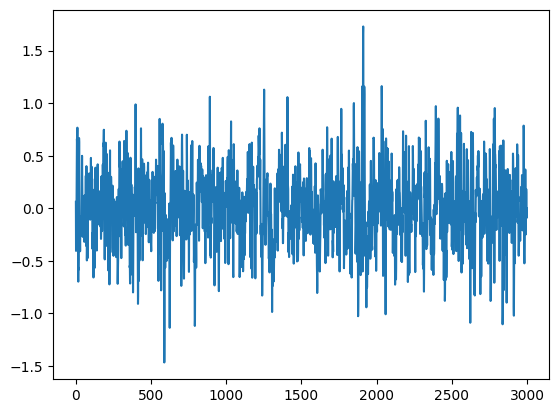

In [32]:
#plot X[1]

from matplotlib import pyplot as plt
x = (X[100, 0, :] - mean[0]) / std[0]
plt.plot(x)

In [24]:
filepath = "/home/guido/dcsm/data/sleep/DCSM/"

for file in os.listdir(filepath):
    file = filepath + file + "/"
    hyp = pd.read_csv(os.path.join(file, "hypnogram.ids"), header=None)
    
    stages = hyp.iloc[:, 2]
    durations = hyp.iloc[:, 1]
    
    # for each stage compute its overall duration during the night
    
    for stage in np.unique(stages):
        print(f"stage {stage}: {np.sum(durations[stages == stage])/np.sum(durations):.2f}")
    
    break

    



stage N1: 0.03
stage N2: 0.18
stage N3: 0.07
stage REM: 0.09
stage W: 0.62


In [11]:
# for each subject_id in table get the starting_index and the num_samples

for subject_id, starting_index, num_samples in zip(
    table["subject_id"], table["start_index"], table["num_samples"]
):
    print(f"subject_id: {subject_id}")
    print(f"starting_index: {starting_index}")
    print(f"num_samples: {num_samples}")

    # get the labels for this subject
    subject_labels = y[starting_index : starting_index + num_samples]
    print(subject_labels[:10])
    print(subject_labels.shape)
    # crop the first 30 minutes of the signal and the last 30 minutes considering that each sample is 30 seconds
    subject_labels = subject_labels[ 60 * 2:]
    print(subject_labels.shape)
    # print the label distribution for this subject
    for label in np.unique(subject_labels):
        print(f"label {label}: {np.sum(subject_labels == label)/len(subject_labels):.2f}")
    break
    print()

subject_id: 0
starting_index: 0
num_samples: 2694
[2 2 2 2 2 2 2 2 2 2]
(2694,)
(2574,)
label 0: 0.65
label 1: 0.03
label 2: 0.17
label 3: 0.07
label 4: 0.09
